## Taichung DE forecast by LSTM

Data source :  TaiChung DE PV plant, CWB WUQI weather.

Time period : 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

Try LSTM to forecast.

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Data processing

Visualizing data.

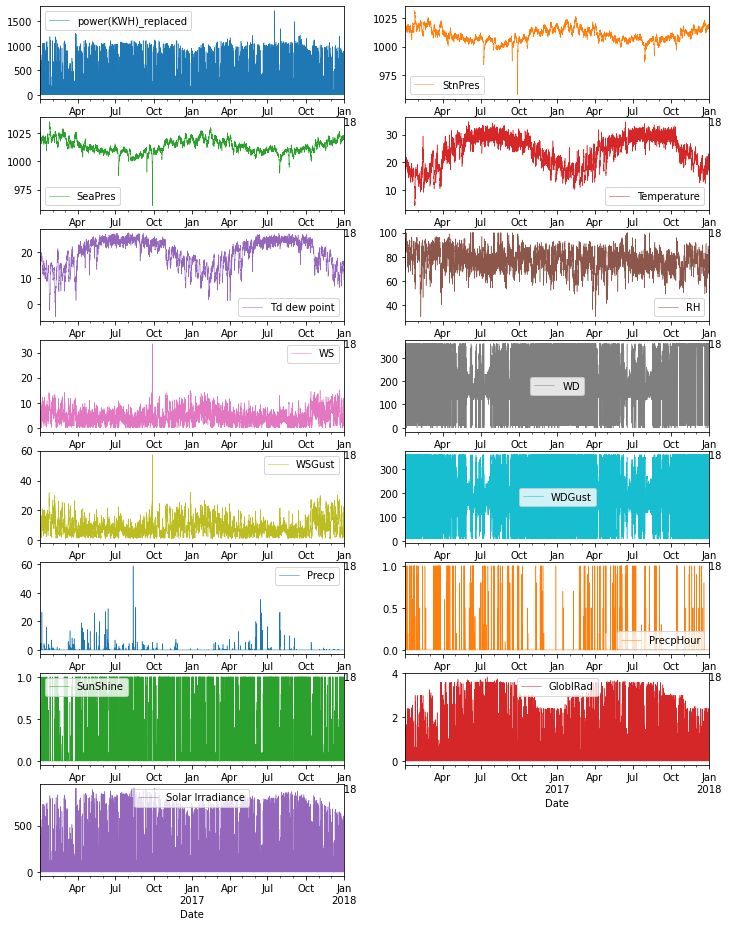

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(8, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

power(KWH)_replaced : PV plant produce energy ($KWH$).

StnPres : station pressure ($hPa$).

SeaPres :  sea surface pressure ($hPa$).

Temperature : temperature ($^{\circ}C$).

Td dew point : dew point temperature($^{\circ}C$).

RH : relative humidity ($\%$).
    
WS :  wind speed($m/s$).

WD :  wind direction ($^{\circ}$).

WSGust :   the maximum gust wind speed($m/s$).

WDGust :   the maximum gust wind direction ($^{\circ}$).

Precp : precipitation ($mm$).

PrecpHour : precipitation duration($Hour$).

SunShine : sunshine duration($Hour$).

GlobRad : global radiation($MJ/m^{2}$).

Solar Irradiance : solar irradiance ($KJ/m^{2}$)

Contain outlier, replace.

Let data in  $mean - 3 \times std < data < mean + 3 \times std $ .

Don't care night , choose day time .

In [3]:
# replace outlier
def replace_outlier(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    lower = series_mean - 3 * series_std
    series_new = np.where(series > upper, upper, np.where(series < lower, lower, series))
    return series_new
# choose day time
daytime_idx = ((6<= data.index.hour) & (data.index.hour<= 18))

for col in data.columns:
    data.loc[daytime_idx,col] = replace_outlier(data.loc[daytime_idx,col])

print(data[daytime_idx].describe().transpose())

                      count         mean         std         min         25%  \
power(KWH)_replaced  9503.0   386.390656  349.470772    0.000000    56.00000   
StnPres              9503.0  1010.017104    5.922215  991.783876  1005.90000   
SeaPres              9503.0  1013.114979    5.992838  994.676048  1009.00000   
Temperature          9503.0    24.368349    5.722668    7.162121    19.70000   
Td dew point         9503.0    19.659760    5.599656    2.742113    15.40000   
RH                   9503.0    75.614142    9.091097   47.962242    70.00000   
WS                   9503.0     5.052438    2.775342    0.000000     3.00000   
WD                   9503.0   255.102073  119.531531    0.000000   170.00000   
WSGust               9503.0    10.006392    5.374613    1.100000     6.00000   
WDGust               9503.0   220.930233  131.512571   10.000000   110.00000   
Precp                9503.0     0.107764    0.533163    0.000000     0.00000   
PrecpHour            9503.0     0.042590

Drop WS, WD, WDGust and WDGust because this is PV forecast.

Drop Precp and PrecpHour ,because 75% data are zero.

In [4]:
data_drop = data[daytime_idx].drop(columns=['WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour'])

# One encoding

Generate morning and afternoon.

In [5]:
data_drop['Hour'] = data_drop.index.hour 
def time_period(hour):
    if 6 <= hour <= 12:
        return 'morning'
    else:
        return 'afternoon'
data_drop['period'] = data_drop['Hour'].apply(time_period)
data_drop = data_drop.join(pd.get_dummies(data_drop['period']))
data_drop.drop(columns=['period'], inplace=True)

# Normalize

Norm min =0, max =1.

In [6]:
X_scale = MinMaxScaler(feature_range=(0, 1))
y_scale = MinMaxScaler(feature_range=(0, 1))
X_norm = X_scale.fit_transform(data_drop.iloc[:,1:])
y_norm = y_scale.fit_transform(data_drop.iloc[:,[0]])

In [7]:
data_scaled_X = pd.DataFrame(X_norm, index=data_drop.index, columns=data_drop.columns[1:])
data_scaled_y = pd.DataFrame(y_norm, index=data_drop.index, columns=[data_drop.columns[0]])
data_scaled = data_scaled_X.join(data_scaled_y)

# Create lag
Choose time lag 1 , 24.

In [8]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        for j in col:
            df[j+'_Lag_' + str(i)] = df[j].shift(i)
    return df

data_lag=create_lags(data_scaled.copy(), data_scaled.columns,[1,13])

data_lag.dropna(inplace=True)

Choose target and feature.

In [9]:
Feature_lag24 = data_lag.iloc[:,-data_scaled.shape[1]:]
Feature_lag1 = data_lag.iloc[:,-2*data_scaled.shape[1]:-data_scaled.shape[1]]
Target = data_lag['power(KWH)_replaced']
Feature = np.stack([Feature_lag1,Feature_lag24],axis=2)

Split train test datasets.

Choose last 4 month for validation.

In [10]:
# split train test data
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.166,shuffle=False)

# Build model

Build LSTM model.

In [11]:
def build_Model(shape):

    model = Sequential()
    model.add(LSTM(100, input_shape=(shape[1],shape[2],), activation='relu', return_sequences=True))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam"
                ,metrics=['mean_squared_error'])
    return model

model = build_Model(X_train.shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 100)           41200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=2,  callbacks=[callback])

Epoch 1/1000
62/62 - 3s - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 2/1000
62/62 - 1s - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 3/1000
62/62 - 1s - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 4/1000
62/62 - 1s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 5/1000
62/62 - 1s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 6/1000
62/62 - 1s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 7/1000
62/62 - 1s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 8/1000
62/62 - 1s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 9/1000
62/62 - 1s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 10/1000
62/62 - 1s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 11/1000
62/62 - 1s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 12/1000
62/62 - 1s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 13/1000
62/62 - 1s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 14/1000
62/62 - 1s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/1000
62/62 - 1s - loss: 0.0050 - m

Epoch 120/1000
62/62 - 2s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 121/1000
62/62 - 2s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 122/1000
62/62 - 2s - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 123/1000
62/62 - 2s - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 124/1000
62/62 - 2s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 00124: early stopping


# Visualizing result.

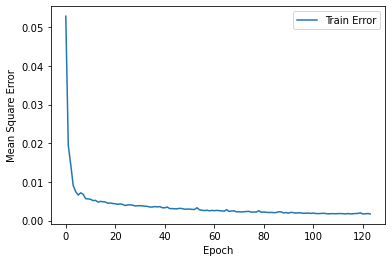

In [13]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.legend()

# The patience parameter is the amount of epochs to check for improvement

plot_history(history)


In [14]:
y_test_value = y_scale.inverse_transform(y_test.values.reshape(-1, 1))
y_predict_norm = model.predict(X_test)
y_predict = y_scale.inverse_transform(y_predict_norm)

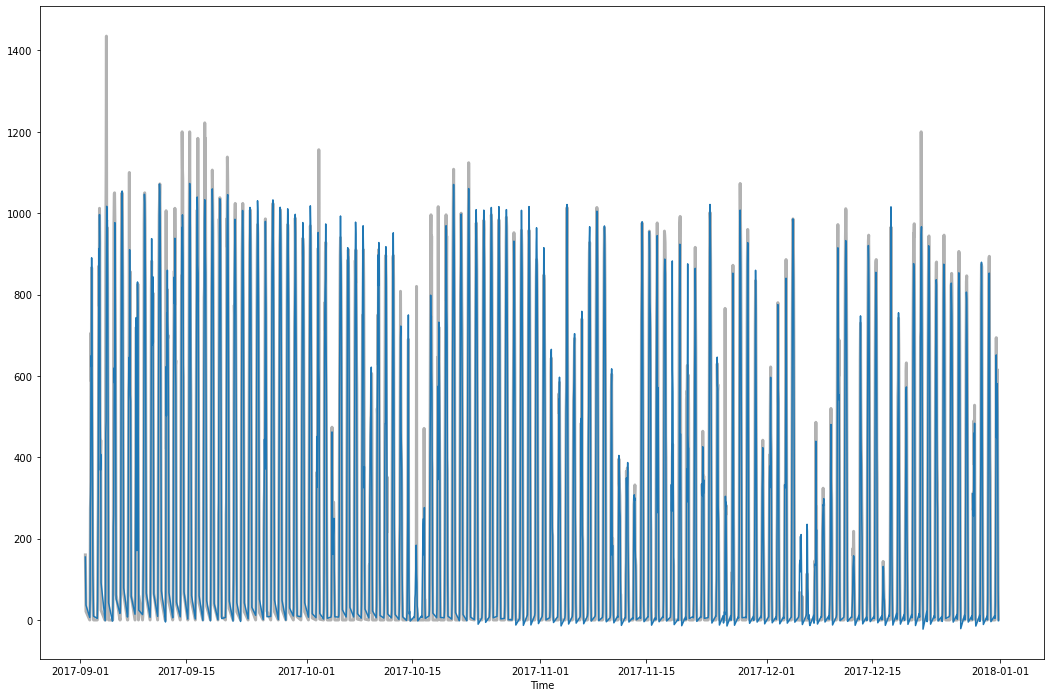

In [15]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test.index, y_test_value, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict)
ax.set(xlabel="Time")
plt.show()

Model Score 

predict value : $ \hat{y}$  

actual value : $y$  

max of y : $y_{max}$

Mean squared error :

$$ \frac{1}{n} \sum_{k=1}^n ({y_{k} -\hat{y_{k}}})^2 $$

Mean absoluate error :

$$ \frac{1}{n} \sum_{k=1}^n \vert {y_{k} -\hat{y_{k}}} \vert $$

Mean relative error :

$$ \frac{100\%}{n} \sum_{k=1}^n \frac{{y_{k} -\hat{y_{k}}}}{y_{max}}  $$

Coefficient of determination :

$$ R^{2} \equiv 1 - \frac {SS_{res}}{SS_{tot}}$$

$$SS_{res} = \sum_{k=1}^n  { (\hat{y_{k}} - \tilde {y})^2}   ,SS_{tot} = \sum_{k=1}^n  { ({y_{k}} - \tilde {y})^2} 
, \tilde {y} = \frac{1}{n} \sum_{k=1}^n {y_{k}} $$

<!-- Mean absoluate percentage error :

% $$ \frac{100\%}{n} \sum_{k=1}^n \vert \frac{{y_{k} -\hat{y_{k}}}}{y_{k}} \vert $$ -->

In [16]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

print('Mean squared error:{:.4f}'.format(mean_squared_error(y_test_value, y_predict)))
print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test_value,y_predict)))
print('Mean relative error:{:.2%}'.format(MRE(y_test_value, y_predict)))
print('Coefficient of determination:{:.4f}'.format(r2_score(y_test_value, y_predict)))

Mean squared error:8381.8839
Mean absolute error:43.2611
Mean relative error:3.01%
Coefficient of determination:0.9325
